In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Packages needed and Importing Libraries

In [2]:
!pip install openpyxl  --quiet

In [3]:
!pip install rouge-score
!pip install datasets

In [4]:
import pandas as pd
import numpy as np
from datasets import load_metric
metric = load_metric("rouge")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [6]:
ENCODER_LEN = 1000
DECODER_LEN = 90
BATCH_SIZE = 16
BUFFER_SIZE = 60000 #This value should be equal to more than the training set, which is around 58000 for our case

# Dataset

After creating the dataframe we apply Start of Sentence(<SOS>) and End of Sentence(<EOS>) tokens. 
These sentences are then tokenized and padded to fix length.

In [7]:
news = pd.read_csv("/content/drive/MyDrive/DL Project/train.csv")
news = news.sample(frac=0.2)
news.drop(['id'], axis=1, inplace=True)
news.head()

,article,highlights
125488,"(Rolling Stone) -- For Neil Young, the Sixties...",Psychedelic Pill is Young's second album of 20...
60448,By . Daily Mail Reporter . PUBLISHED: . 10:27 ...,Tennis hero thwarted in bid for new course in ...
161211,A manhunt has been launched to find a pregnant...,"Aubrey Andrews, 20, 'drove to a friend's house..."
220865,Washington (CNN) -- Anticipating possible poli...,Texas senator believes cuts may not be as bad ...
149583,"By . Paul Thompson . PUBLISHED: . 11:21 EST, 7...","Kayla Garcia, 4, died on May 9 after she was a..."


In [8]:
news.shape

(57423, 2)

In [9]:
article = news['article']
summary = news['highlights']
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [10]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [11]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

#### Vocabulary of our encoder and decoder

In [12]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

331846 100742


### 

In [13]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Transformer Model

The next several blocks of code contain the vanilla Transformer model.

If you want to know about what they are and how they work I suggest this video: https://www.youtube.com/watch?v=4Bdc55j80l8

It does an excellent job of giving an overview about them and helped me in understanding them.

In [15]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [20]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [21]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 5

# Custom Learning Rate

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [23]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

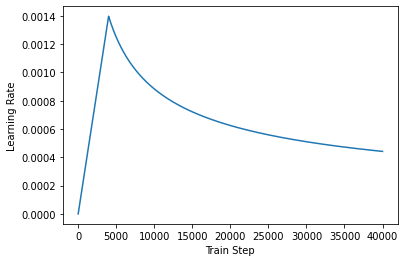

In [24]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Custom Loss and Accuracy

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [26]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [27]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [28]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [46]:
checkpoint_path = "/content/drive/MyDrive/DL Project"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [30]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Training the Model

In [47]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.8872 Accuracy 0.1559
Epoch 1 Batch 100 Loss 5.9928 Accuracy 0.1560
Epoch 1 Batch 200 Loss 6.0031 Accuracy 0.1561
Epoch 1 Batch 300 Loss 6.0126 Accuracy 0.1562
Epoch 1 Batch 400 Loss 6.0146 Accuracy 0.1563
Epoch 1 Batch 500 Loss 6.0172 Accuracy 0.1564
Epoch 1 Batch 600 Loss 6.0146 Accuracy 0.1565
Epoch 1 Batch 700 Loss 6.0202 Accuracy 0.1566
Epoch 1 Batch 800 Loss 6.0231 Accuracy 0.1567
Epoch 1 Batch 900 Loss 6.0268 Accuracy 0.1568
Epoch 1 Batch 1000 Loss 6.0360 Accuracy 0.1569
Epoch 1 Batch 1100 Loss 6.0398 Accuracy 0.1570
Epoch 1 Batch 1200 Loss 6.0445 Accuracy 0.1571
Epoch 1 Batch 1300 Loss 6.0453 Accuracy 0.1572
Epoch 1 Batch 1400 Loss 6.0491 Accuracy 0.1573
Epoch 1 Batch 1500 Loss 6.0514 Accuracy 0.1574
Epoch 1 Batch 1600 Loss 6.0556 Accuracy 0.1575
Epoch 1 Batch 1700 Loss 6.0576 Accuracy 0.1575
Epoch 1 Batch 1800 Loss 6.0606 Accuracy 0.1576
Epoch 1 Batch 1900 Loss 6.0622 Accuracy 0.1577
Epoch 1 Batch 2000 Loss 6.0643 Accuracy 0.1578
Epoch 1 Batch 2100 Loss 6

# Evaluation

In [33]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [50]:
def summarize(input_article):
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]

# Predictions

Below me make predictions on some texts to see how the model is performimg. Since this was a very basic approach the model won't perform that well but it can surely be improved.

In [51]:
print("Real Headline : ", summary.iloc[16][5:-5],"\nPredicted Summary : ", summarize(article.iloc[16]))

Real Headline :   The mother, who cannot be named, pleaded guilty to producing and disseminating child abuse material .
Her husband said she should not be imprisoned but instead be allowed back home .
She took naked photos of her daughters allegedly at the request of their Sydney dance teacher Grant Davies .
Davies ran a studio in Sydney's inner west and trained performers for his productions like Billy Elliot .  
Predicted Summary :  the former pm was accused of having sex with her mother in a young girl he was jailed for four years for four years for sex offences the teenager was jailed for four years for the assault


In [52]:
print("Real Headline : ", summary.iloc[23][5:-5],"\nPredicted Summary : ", summarize(article.iloc[23]))

Real Headline :   The photographs were taken at Namburg National Park by self-taught Perth astrophotographer Michael Goh .
He sometimes spends all night out in the elements and they have won the father-of-two a swag of awards .
Goh said he was constantly competing with the weather to take the perfect shot, so he always had a camera ready .  
Predicted Summary :  the pair were spotted in the northern territory in the northern territory the pair were spotted in the northern territory in the northern territory the pair were spotted in the northern territory in the northern territory


In [53]:
rouge_score = load_metric("rouge")

In [88]:
dict1 = {'original_summary':[], 'pred_summary':[]}

for i in range(150,161):
    dict1['original_summary'].append(summary.iloc[i][5:-5])
    dict1['pred_summary'].append(summarize(article.iloc[i]))

predicted_df2 = pd.DataFrame.from_dict(dict1)

In [92]:
predicted_df2.to_csv('/content/drive/MyDrive/DL Project/Transformer-predictions.csv', index = False)

In [93]:
df = pd.read_csv('/content/drive/MyDrive/DL Project/Transformer-predictions.csv')

In [94]:
list1 = df['original_summary'].tolist()
list2 = df['pred_summary'].tolist()

In [95]:
results2 = metric.compute(predictions=list2, references=list1)

In [91]:
print("ROUGE 1: ", results2["rouge1"].high.fmeasure)
print("ROUGE 2: ", results2["rouge2"].high.fmeasure)
print("ROUGE L: ", results2["rougeL"].high.fmeasure)

ROUGE 1:  0.20666091937111847
ROUGE 2:  0.01733022827899488
ROUGE L:  0.142890160726438
